In [1]:
import os
import sys
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
import math
import custom_module
from custom_module import cifar10
from imp import reload
from custom_module import imageplot


reload(cifar10)
reload(imageplot)

<module 'custom_module.imageplot' from '/home/ubuntu/tensorflow/tf_env_jn/custom_module/imageplot.py'>

In [2]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
test


In [3]:
img_size = 32
img_channels = 3
img_shape = [img_channels, img_size, img_size]
num_classes = 10

# training variable
mini_batch_size = 64
num_training_example = 50000
initial_learning_rate = 0.05
MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.
NUM_EPOCHS_PER_DECAY = 30.0      # Epochs after which learning rate decays.
LEARNING_RATE_DECAY_FACTOR = 0.8  # Learning rate decay factor.

# L2 regularization
# hyperparameter
beta = 0.001

# get images and labels
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True 

In [4]:
images_train, cls_train, cls_hot_train = cifar10.load_training_data()
images_test, cls_test, cls_hot_test = cifar10.load_test_data()

Loading data: /mnt/hdisk/dataset/cifar-10-batches-py/data_batch_1
Loading data: /mnt/hdisk/dataset/cifar-10-batches-py/data_batch_2
Loading data: /mnt/hdisk/dataset/cifar-10-batches-py/data_batch_3
Loading data: /mnt/hdisk/dataset/cifar-10-batches-py/data_batch_4
Loading data: /mnt/hdisk/dataset/cifar-10-batches-py/data_batch_5
Loading data: /mnt/hdisk/dataset/cifar-10-batches-py/test_batch


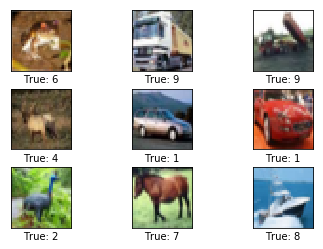

In [5]:
# 显示部分图片
images = images_train[0:9]
cls_true = cls_train[0:9]
imageplot.plot_images(images, cls_true, None)

In [6]:
def activation_summary(x):
    """
    Helper to create summaries for activations.
    Creates a summary that provides a histogram of activations.
    Creates a summary that measures the sparsity of activations.
    """
    
#     tensor_name = re.sub('%s_[0-9]*/' % TOWER_NAME, '', x.op.name)
#     tf.summary.histogram(tensor_name + '/activations', x)
#     tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(x))

In [7]:
def variable_on_cpu(name, shape, initializer):
    """
    Helper to create a variable stored on CPU memory.
    """
#     with tf.device('/cpu:0'):
#         var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    
    var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    
    return var

In [8]:
# create conv weights
def variable_on_weight(name, shape, stddev):
    var = variable_on_cpu(name,
                          shape,
                          tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    # TODO: add weight decay
#     if wd is not None:
#         weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
#         tf.add_to_collection('losses', weight_decay)

    # L2 regularization
    weight_decay = tf.multiply(tf.nn.l2_loss(var), beta, name='weight_loss')
    tf.add_to_collection('losses',weight_decay)
        
    return var

In [9]:
def add_loss_summaries(total_loss):
    """Add summaries for losses in CIFAR-10 model.

      Generates moving average for all losses and associated summaries for
      visualizing the performance of the network.

      Args:
        total_loss: Total loss from loss().
      Returns:
        loss_averages_op: op for generating moving averages of losses.
    """
    # Compute the moving average of all individual losses and the total loss.
    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    losses = tf.get_collection('losses')
    loss_averages_op = loss_averages.apply(losses + [total_loss])

    # Attach a scalar summary to all individual losses and the total loss; do the
    # same for the averaged version of the losses.
    for l in losses + [total_loss]:
        # Name each loss as '(raw)' and name the moving average version of the loss
        # as the original loss name.
        tf.summary.scalar(l.op.name + ' (raw)', l)
        tf.summary.scalar(l.op.name, loss_averages.average(l))

    return loss_averages_op

In [10]:
def create_placeholders():
    
    # data
#     with tf.name_scope('data'):
#         input_image=tf.placeholder(tf.float32, shape=[None, img_size, img_size, img_channels], name='Input')
#         output_result=tf.placeholder(tf.float32, shape=[None, num_classes], name='Output')
    
    input_image=tf.placeholder(tf.float32, shape=[None, img_size, img_size, img_channels], name='Input')
    output_result=tf.placeholder(tf.float32, shape=[None, num_classes], name='Output')
        
    return input_image, output_result

In [11]:
def inference(images):
    
    #ops.reset_default_graph()
    
    # conv1
    with tf.variable_scope('conv1') as scope:
        kernel = variable_on_weight('weights', 
                          shape=[5,5,3,64],
                          stddev=5e-2)
        conv = tf.nn.conv2d(images, kernel, [1,1,1,1],padding='SAME')
        biases = variable_on_cpu('biases',[64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, 'conv1')
        
#     tf.summary.histogram('Convolution_layers/conv1', conv1)
#     tf.summary.scalar('Convolution_layer/conv1', tf.nn.zero_fraction(conv1))      
    
    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1], strides=[1,2,2,1],
                          padding='SAME', name='pool1')
    # batch normlization
    
    
    # conv2
    with tf.variable_scope('conv2') as scope:
        kernel = variable_on_weight('weights',
                                   shape=[5,5,64,64],
                                   stddev=5e-2)
        conv = tf.nn.conv2d(pool1, kernel, [1,1,1,1], padding='SAME')
        biases = variable_on_cpu('biases',[64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, 'conv2')
        
#     tf.summary.histogram('Convolution_layers/conv2', conv2)
#     tf.summary.scalar('Convolution_layer/conv2', tf.nn.zero_fraction(conv2))
    
    # pool2
    pool2 = tf.nn.max_pool(conv2, ksize=[1,3,3,1], strides=[1,2,2,1],
                          padding='SAME', name='pool2')
    # batch normalization
    
    
    # conv3
    with tf.variable_scope('conv3') as scope:
        kernel=variable_on_weight('weights',
                                 shape=[3,3,64,128],
                                 stddev=5e-2)
        conv = tf.nn.conv2d(pool2, kernel, [1,1,1,1], padding='SAME')
        biases = variable_on_cpu('biases',[128], tf.constant_initializer(0.0))
        pre_activation=tf.nn.bias_add(conv, biases)
        conv3 = tf.nn.relu(pre_activation, 'conv3')
        
#     tf.summary.histogram('Convolution_layers/conv3', conv3)
#     tf.summary.scalar('Convolution_layers/conv3', tf.nn.zero_fraction(conv3))
    
    # pool3
    pool3 = tf.nn.max_pool(conv3, ksize=[1,3,3,1], strides=[1,2,2,1],
                          padding='SAME', name='pool3')
    # batch normalization
    
    
    # flatten 
    p = tf.contrib.layers.flatten(pool3)
    
    # fully connected layer 1
    with tf.variable_scope('fully_connected1') as scope:
        dim = p.get_shape()[1].value
        weights = variable_on_weight('weights', 
                                     shape=[dim, 384], 
                                     stddev=5e-2)
        biases = variable_on_cpu('biases',[384],tf.constant_initializer(0.0))
        local3=tf.nn.relu(tf.matmul(p,weights)+biases, name=scope.name)
    
#     tf.summary.histogram('Fully connected layers/fc1', local3)
#     tf.summary.scalar('Fully connected layer/fc1', tf.nn.zero_fraction(local3))
    
    
    # fully connected layer 2
    with tf.variable_scope('fully_connected2') as scope:
        weights = variable_on_weight('weights',
                                    shape=[384, 128],
                                    stddev=5e-2)
        biases = variable_on_cpu('biases', [128], tf.constant_initializer(0.0))
        local4 = tf.nn.relu(tf.matmul(local3, weights)+biases, name=scope.name)
        
#     tf.summary.histogram('Fully connected layers/fc2', local4)
#     tf.summary.scalar('Fully connected layer/fc2', tf.nn.zero_fraction(local4))
    
    
    # output layer
    with tf.variable_scope('output') as scope:
        weights = variable_on_weight('weights',
                                    shape=[128,num_classes],
                                    stddev=5e-2)
        biases = variable_on_cpu('biases',[num_classes], tf.constant_initializer(0.0))
        softmax_linear=tf.add(tf.matmul(local4,weights), biases, name=scope.name)
    
    
#     tf.summary.histogram('Fully connected layers/output', softmax_linear)

    
    return softmax_linear        
            
    

In [12]:
def loss(logits, labels):

#     labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='cross_entropy')
    cost = tf.reduce_mean(cross_entropy,name='cost')
      
    # L2 regularization
    tf.add_to_collection('losses', cost)
    
    # 损失函数中，除了交叉熵损失之外，还有W的L2损失
    return tf.add_n(tf.get_collection('losses'))
    #return cost

In [13]:
# 创建输入和输出的placeholder
images, labels = create_placeholders()
# 记录训练次数
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

add_global = global_step.assign_add(1)

# learning rate decay
learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                           global_step=global_step,
                                           decay_steps=5,decay_rate=0.5)

# 最后一层网络输出
logits = inference(images)
# 损失函数（交叉熵+L2）
loss = loss(logits, labels)
# 优化函数
# TODO: 用Adam优化
# optimizer = tf.train.RMSPropOptimizer(learning_rate=initial_learning_rate).minimize(loss, global_step=global_step)
#optimizer = tf.train.AdamOptimizer(learning_rate=initial_learning_rate).minimize(loss)
with tf.control_denpendices([add_global]):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)


AttributeError: module 'tensorflow' has no attribute 'control_denpendices'

In [ ]:
# 计算准确率
correct_prediction=tf.equal(tf.argmax(logits, axis=1), tf.argmax(labels, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 加入tensorboard
#tf.summary.scalar("Accuracy/train", accuracy)


# merged=tf.summary.merge_all()
# save_dir="checkpoints/"
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
# save_path = os.path.join(save_dir, 'train_param')


#saver = tf.train.Saver()
#train_writer=tf.summary.FileWriter(_SAVE_PATH, sess.graph)

In [ ]:
def cal_accuracy(X_input, cls_pred, sess, mini_batch_size=64):
    
    num_examples = X_input.shape[0]
    num_minibatches = math.floor(num_examples/mini_batch_size)
    
    # shuffler mini batches
    minibatches = cifar10.random_mini_batches(X_input,
                                             cls_pred,
                                             num_minibatches,
                                             mini_batch_size,
                                             0)
    accuracy_value = 0.
    
    for minibatch in minibatches:
        # select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        temp_acc = sess.run(accuracy,feed_dict={images:minibatch_X, labels:minibatch_Y})
        accuracy_value += temp_acc
        
    accuracy_value = accuracy_value/num_minibatches
    
    return accuracy_value

In [14]:
def train(num_epoch):
    
    init = tf.global_variables_initializer()
    
    # random mini batch seed
    seed=0
    
    with tf.Session(config=config) as sess:
        sess.run(init)
        
        # Do the train loop
        for epoch in range(num_epoch):
            minibatch_cost = 0.
            
            num_minibatches=math.floor(num_training_example/mini_batch_size)
            seed = seed+1
            
            minibatches = cifar10.random_mini_batches(images_train, 
                                                      cls_hot_train,
                                                      num_minibatches,
                                                      mini_batch_size,
                                                      seed)
            for minibatch in minibatches:
                # select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer, loss], 
                                        feed_dict={images:minibatch_X, labels:minibatch_Y})
                minibatch_cost += temp_cost
            
            minibatch_cost = minibatch_cost/num_training_example
            
            
            # print training information
            if epoch%1==0:
                # get learning rate
                cur_learning_rate = sess.run(learning_rate)
                print("Cost after epoch {0}: {1:>.5f}, with learning rate {2:>.4f}".format(epoch, minibatch_cost, cur_learning_rate))
                
            # print testing information
            if epoch%1==0:
                test_accuracy = cal_accuracy(images_test, cls_hot_test, sess, mini_batch_size=64)
                train_accuracy = cal_accuracy(images_train, cls_hot_train, sess, mini_batch_size=64)
                # format the prints
                print("Train accuracy {0:>6.1%}, Test accuracy {1:>6.1%}, ".format(train_accuracy,test_accuracy))        
    

In [15]:
# 基本版卷积网络
# TODO: 
# 1.learning rate decay(Adam是否已经增加了Learning rate decay)
# 2.batch normalization
# 3.dropout
# 4.L2 regularition
# 5.input expend
# 6.记录训练数据
# 7.在tensorboard中显示数据

# step 1.
# GradientDescentOptimizer, L2 regularization, learning rate=0.001
# epoch=60时，test train的accuracy 60%左右
# 问题：训练速度太慢，提高训练速度
# step 2.
# 提高learning rate=0.05
# epoch=13时，train accuracy=87%， test accuracy=73%
# 准确率达到顶峰，之后训练集的准确率存在波动，需要调整learning rate
# step 3.
# 添加learning rate decay
# decayed_learning_rate = learning_rate *
#                         decay_rate ^ (global_step / decay_steps)


train(100)

NameError: name 'optimizer' is not defined